# Fake News Detection Project

## Importing Libraries

In [3]:
# Importing libraries
import nltk
import re
import sklearn
import csv
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# Importing word processing libraries
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# Importing vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Importing libraries for the Naiive Bayes model
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Importing libraries for the LSTM model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from scipy.sparse import csr_matrix

# Importing libraries for evaluation
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix

C:\Users\65918\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Importing the Datasets

In [4]:
#reading the csv file and storing it to the raw_data dataframe
# https://www.kaggle.com/datasets/rajatkumar30/fake-news/
raw_data = pd.read_csv("news/news.csv")

#reading the csv file and storing it to the true_data, fake_data dataframes
#https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets
true_data = pd.read_csv("true/true.csv")
fake_data = pd.read_csv("fake/fake.csv")

### About Dataset 1: News.csv

In [5]:
# finding out the column names of the dataset
raw_data.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

#### Size of the Dataset

In [6]:
# finding out the size of the extracted datset
raw_data.shape

(6335, 4)

#### Viewing a few entries of the Dataset

In [7]:
# displaying a few rows of the dataset
raw_data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


#### Viewing the breakdown of the Dataset labels

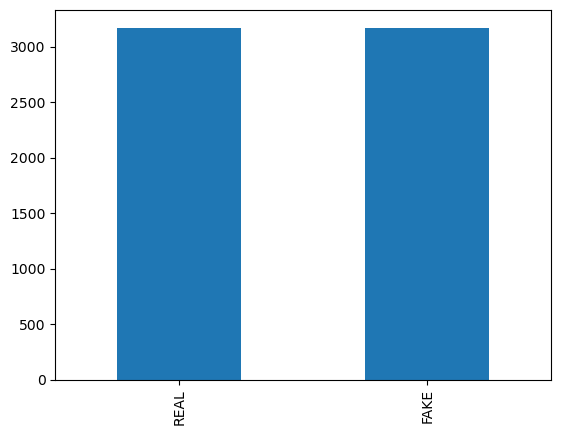

In [8]:
raw_breakdown = raw_data['label'].value_counts()
# Plot the value counts as a bar chart
raw_breakdown.plot(kind='bar')
plt.show()

### About Dataset 2 & 3: True.csv, Fake.csv

In [9]:
# finding out the column names of the dataset
true_data.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [10]:
# finding out the column names of the dataset
fake_data.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

#### Size of the Datasets

In [11]:
# finding out the size of the extracted datset
true_data.shape 

(21417, 4)

In [12]:
# finding out the size of the extracted datset
fake_data.shape

(23481, 4)

#### Viewing a few entries of the Datasets

In [13]:
# displaying a few rows of the dataset
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [14]:
# displaying a few rows of the dataset
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


## Data Pre-Processing

Setting the labels of true data to be true and fake_data to be fake

In [15]:
true_data["label"] = "TRUE"
fake_data["label"] = "FAKE"

Dropping columns that are unneccessary

In [16]:
true_data = true_data.drop(columns= ["subject", "date"])
fake_data = fake_data.drop(columns= ["subject", "date"])

Combining the true and fake datasets to become a combined dataset

In [17]:
combined_data = pd.concat([true_data, fake_data], axis=0, ignore_index=True)

#### Viewing a few entries of the combined Dataset

In [18]:
# displaying a few rows of the dataset
combined_data.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,TRUE
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,TRUE
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,TRUE
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,TRUE
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,TRUE


#### Viewing the breakdown of the combined Dataset labels

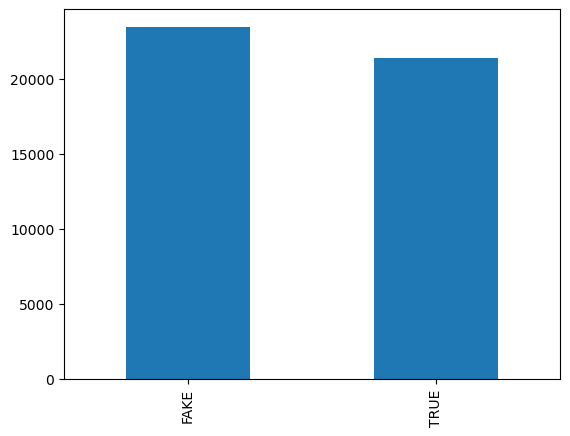

In [19]:
combined_dataset_breakdown = combined_data['label'].value_counts()
# Plot the value counts as a bar chart
combined_dataset_breakdown.plot(kind='bar')
plt.show()

Setting labels that are fake to be 0 and labels that are true to be 1 

In [20]:
raw_data['label'] = raw_data.label.map({'FAKE':0, 'REAL':1})
combined_data['label'] = combined_data.label.map({'FAKE':0, 'TRUE':1})

Merging Dataset 1 with the combined dataset(of Dataset 2 & 3)

In [21]:
merged_data = pd.concat([raw_data, combined_data], axis=0, ignore_index=True)

#### Size of the Merged Dataset

In [22]:
# finding out the size of the extracted datset
merged_data.shape

(51233, 4)

#### Viewing a few entries of the combined Dataset

In [23]:
# displaying a few rows of the dataset
merged_data.head()

,Unnamed: 0,title,text,label
0,8476.0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294.0,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608.0,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142.0,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875.0,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


#### Viewing the total breakdown of the Merged Dataset's labels

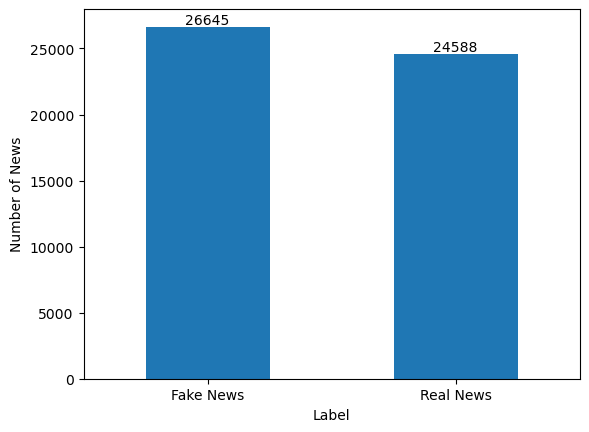

In [24]:
total_breakdown = merged_data['label'].value_counts()
# Plotting the total breakdown of the merged dataset label value counts as a bar chart
ax = total_breakdown.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Number of News')
custom_labels = ['Fake News', 'Real News']
ax.set_xticklabels(custom_labels, rotation=0)

# Displaying the value counts of the label
for i, count in enumerate(total_breakdown):
    ax.text(i, count + 0.1, str(count), ha='center', va='bottom')
plt.show()

There are 2057 more Fake News articles than Real News articles.

I plan to remove 3 Real News articles and 2060 Fake News articles to balance the dataset.

In [25]:
print(26645-24585)

2060


### Cleaning the data by making the letters lowercase, removing punctuation and stopwords

In [26]:
# Function to remove punctuation etc
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    return text

# Function to remove stopwords and make the words lowercase etc
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Function to clean the data overall
def clean_data(text):
    cleaned_text = text.lower()
    cleaned_text = remove_punctuation(cleaned_text)
    cleaned_text = remove_stopwords(cleaned_text)
    return cleaned_text

In [27]:
# creating a new data copy before cleaning the data in the dataset
cleaned_data = merged_data.copy()
print(cleaned_data['text'])

0        Daniel Greenfield, a Shillman Journalism Fello...
1        Google Pinterest Digg Linkedin Reddit Stumbleu...
2        U.S. Secretary of State John F. Kerry said Mon...
3        — Kaydee King (@KaydeeKing) November 9, 2016 T...
4        It's primary day in New York and front-runners...
                               ...                        
51228    21st Century Wire says As 21WIRE reported earl...
51229    21st Century Wire says It s a familiar theme. ...
51230    Patrick Henningsen  21st Century WireRemember ...
51231    21st Century Wire says Al Jazeera America will...
51232    21st Century Wire says As 21WIRE predicted in ...
Name: text, Length: 51233, dtype: object


In [28]:
# cleaning the data in the dataset
cleaned_data['text'] = cleaned_data['text'].apply(clean_data)
# print the data to see if the data have been cleaned
print(cleaned_data['text'])

0        daniel greenfield shillman journalism fellow f...
1        google pinterest digg linkedin reddit stumbleu...
2        us secretary state john f kerry said monday st...
3        — kaydee king kaydeeking november 9 2016 lesso...
4        primary day new york frontrunners hillary clin...
                               ...                        
51228    21st century wire says 21wire reported earlier...
51229    21st century wire says familiar theme whenever...
51230    patrick henningsen 21st century wireremember o...
51231    21st century wire says al jazeera america go h...
51232    21st century wire says 21wire predicted new ye...
Name: text, Length: 51233, dtype: object


### Making data balanced

Removing the 2060 Fake News articles and 3 Real News articles.

In [29]:
# creating a new data copy before balancing the dataset
balanced_data = cleaned_data.copy()
# dropping 2060 Fake News articles
balanced_data = balanced_data.drop(balanced_data[balanced_data['label'] == 0].head(2060).index)
# dropping 3 Real News articles
balanced_data = balanced_data.drop(balanced_data[balanced_data['label'] == 1].head(3).index)

### Removing redundant data

Dropping unlabelled data

In [30]:
# creating a new data copy before removing redundant data from the dataset
complete_data = balanced_data.copy()
# dropping unlabelled articles
complete_data = complete_data.dropna(subset=['label'])
# dropping an unneccessary column
complete_data = complete_data.drop(['Unnamed: 0'], axis=1)
# resetting the index of the dataset
complete_data = complete_data.reset_index(drop=True)

In [31]:
# displaying a few rows of the dataset
complete_data.head()

,title,text,label
0,Fact check: Trump and Clinton at the 'commande...,hillary clinton donald trump made inaccurate c...,1
1,Iran reportedly makes new push for uranium con...,iranian negotiators reportedly made lastditch ...,1
2,"With all three Clintons in Iowa, a glimpse at ...",cedar rapids iowa — “ one wonderful rallies en...,1
3,Donald Trump’s Shockingly Weak Delegate Game S...,donald trump ’ organizational problems gone ba...,1
4,"Trump takes on Cruz, but lightly",killing obama administration rules dismantling...,1


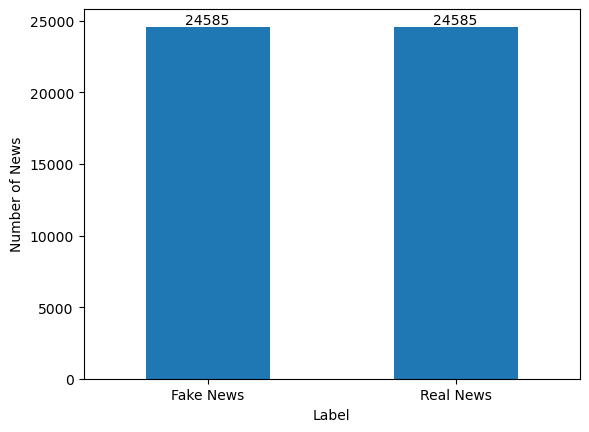

In [32]:
updated_breakdown = complete_data['label'].value_counts()
# Plotting the updated breakdown of the final complete dataset label value counts as a bar chart
ax = updated_breakdown.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Number of News')
custom_labels = ['Fake News', 'Real News']
ax.set_xticklabels(custom_labels, rotation=0)

# Displaying the updated value counts of the labels in the dataset
for i, count in enumerate(updated_breakdown):
    ax.text(i, count + 0.1, str(count), ha='center', va='bottom')
plt.show()

## Preparing Feature Extractors

### Count Vectorizer

In [33]:
# initializing the Count vectorizer
count_vectorizer = CountVectorizer()
print(count_vectorizer)

CountVectorizer()


### TF-IDF Vectorizer

In [34]:
# initializing the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
print(tfidf_vectorizer)

TfidfVectorizer()


### Assigning the Data

In [35]:
# assigning the X and y variables with the article data and labels
X = complete_data['text']
y = complete_data['label']

### Splitting the Data

In [36]:
# Splitting the X_train, y_train, X_test, y_test variables such that the test size if 0.2 of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# fitting the Count vectorizer with the X_train data
count_train = count_vectorizer.fit_transform(X_train)
# fitting the IF-IDF vectorizer with the X_train data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [38]:
# transforming the Count vectorizer with the X_test data
count_test = count_vectorizer.transform(X_test)
# transforming the TF-IDF vectorizer with the X_test data
tfidf_test = tfidf_vectorizer.transform(X_test)

## Training the Baseline Model

### Importing the baseline model

In [39]:
# Initializing the Naive Bayes Model
nb = MultinomialNB()

### Training the baseline model with the different feature extractor data

In [40]:
# Fitting the Naive Bayes Model using the Count vectorizer data and y_train data
multi_nb_count = nb.fit(count_train, y_train)
# Fitting the Naive Bayes Model using the TF-IDF vectorizer data and y_train data
multi_nb_tfidf = nb.fit(tfidf_train, y_train)

### Making predictions with the baseline model on the 2 feature extractor's data

In [41]:
# storing the Naive Bayes Model predictions using the Count vectorizer
nb_count_pred = nb.predict(count_test)
# storing the Naive Bayes Model predictions using the TF-IDF vectorizer
nb_tfidf_pred = nb.predict(tfidf_test)

### Results of the baseline model using the 2 different feature extractor's data

In [42]:
# storing the Naive Bayes Model score using the Count vectorizer
score1 = metrics.accuracy_score(y_test, nb_count_pred)
# storing the Naive Bayes Model score using the TF-IDF vectorizer
score2 = metrics.accuracy_score(y_test, nb_tfidf_pred)

In [43]:
# printing the Naive Bayes Model scores using the 2 vectorizers
print("Accuracy Scores of Naive Bayes model:")
print("Using Count Vectorizer:", score1*100, "%")
print("Using TF-IDF Vectorizer:", score2*100, "%")

Accuracy Scores of Naive Bayes model:
Using Count Vectorizer: 88.0923327232052 %
Using TF-IDF Vectorizer: 89.04820012202562 %


### Making improvements to the baseline model

In [44]:
# preparing a parameter grid to improve the model
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}

In [45]:
# Using GridSearchCV to train the Naive Bayes model using the Count vectorizer data
improved_nb_count = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy')
improved_nb_count.fit(count_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]},
             scoring='accuracy')

In [46]:
# Using GridSearchCV to train the Naive Bayes model using the TF-IDF vectorizer data
improved_nb_tfidf = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy')
improved_nb_tfidf.fit(tfidf_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]},
             scoring='accuracy')

### Making predictions with the improved baseline model on the 2 feature extractor's data

In [47]:
# Using the improved Naive Bayes model using the Count vectorizer data to make new predictions
improved_count_pred = improved_nb_count.predict(count_test)
# Using the improved Naive Bayes model using the TF-IDF vectorizer data to make new predictions
improved_tfidf_pred = improved_nb_tfidf.predict(tfidf_test)

### Results of the improved baseline model using the 2 different feature extractor's data

In [48]:
# Storing the improved Naive Bayes model score(using the Count vectorizer data)
improved_count_score = metrics.accuracy_score(y_test, improved_count_pred)
# Storing the improved Naive Bayes model score(using the TF-IDF vectorizer data)
improved_tfidf_score = metrics.accuracy_score(y_test, improved_tfidf_pred)

In [49]:
# printing the Naive Bayes Model scores using the 2 vectorizers, after being improved
print("Accuracy Scores of Naive Bayes model(improved):")
# Printing the improved Naive Bayes model score(using the Count vectorizer data)
print("Using Count Vectorizer:", improved_count_score*100, "%")
# Printing the improved Naive Bayes model score(using the TF-IDF vectorizer data)
print("Using TF-IDF Vectorizer:", improved_tfidf_score*100, "%")

Accuracy Scores of Naive Bayes model(improved):
Using Count Vectorizer: 92.70896888346553 %
Using TF-IDF Vectorizer: 91.04128533658735 %


We can see that the Count Vectorizer has a better accuracy score when used with the improved Naive Bayes model on the test data. Hence, we will be using this vectorizer and model from hereon.

### Storing the trained Baseline model (Naive Bayes) and the more suitable vectorizer(Count Vectorizer)

In [50]:
# storing the Count vectorizer in the vectorizer.pkl file
pickle.dump(count_vectorizer, open('vectorizer.pkl', 'wb'))

In [51]:
# storing the Naive Bayes model in the initial_nb_model.pkl file
pickle.dump(nb, open('initial_nb_model.pkl', 'wb'))

In [52]:
# storing the improved Naive Bayes model in the improved_nb_model.pkl file
pickle.dump(improved_nb_count, open('improved_nb_model.pkl', 'wb'))

In [61]:
# reading back the Count vectorizer in the vectorizer.pkl file
load_vectorizer=pickle.load(open('vectorizer.pkl', 'rb'))

In [54]:
# reading back the Naive Bayes model in the initial_nb_model.pkl file
load_nb_model=pickle.load(open('initial_nb_model.pkl', 'rb'))

In [138]:
# reading back the improved Naive Bayes model in the improved_nb_model.pkl file
load_improved_nb_model=pickle.load(open('improved_nb_model.pkl', 'rb'))

## Training the LSTM Model

### Initializing the Tokenizer

In [63]:
# initializing a Tokenizer
tokenizer = Tokenizer()

### Assigning the X_lstm and y_lstm data

In [64]:
# fitting the texts on the tokenizer
tokenizer.fit_on_texts(X)
# fitting the texts on the tokenizer
X_lstm = tokenizer.texts_to_sequences(X)
# padding sequences to ensure consistent length for LSTM input
X_lstm = pad_sequences(X_lstm)

In [65]:
# initializing the label encoder
le = LabelEncoder()
# encode the labels for binary classification
y_lstm = le.fit_transform(y)

### Splitting the Data

In [66]:
# Splitting the X_train, y_train, X_test, y_test variables such that the test size if 0.2 of the dataset
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

### Preparing the LSTM Model

In [67]:
# setting the vocabulary size of the dataset for the LSTM model 
voc_size = len(tokenizer.word_index) + 1
# setting the vectorizer features size of the dataset for the LSTM model 
embedding_vector_features = 100
# setting the number of lstm units for the LSTM model 
lstm_units = 50

In [67]:
# Preparing the LSTM model
LSTM_model = Sequential()
LSTM_model.add(Embedding(voc_size, embedding_vector_features, input_length=(X_train_lstm.shape[1])))
LSTM_model.add(LSTM(units=lstm_units, input_shape=(voc_size, embedding_vector_features)))
LSTM_model.add(Dense(1, activation='sigmoid'))
LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(LSTM_model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10786, 100)        24926500  
                                                                 
 lstm (LSTM)                 (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 24956751 (95.20 MB)
Trainable params: 24956751 (95.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### Fitting the LSTM Model with the Training data

In [68]:
history = LSTM_model.fit(X_train_lstm, y_train_lstm, epochs=2, batch_size=64)

Epoch 1/2


615/615 [==============================] - 16156s 26s/step - loss: 0.1698 - accuracy: 0.9389
Epoch 2/2
615/615 [==============================] - 15143s 25s/step - loss: 0.0660 - accuracy: 0.9791


### Plotting loss and accuracy graphs of the LSTM Model

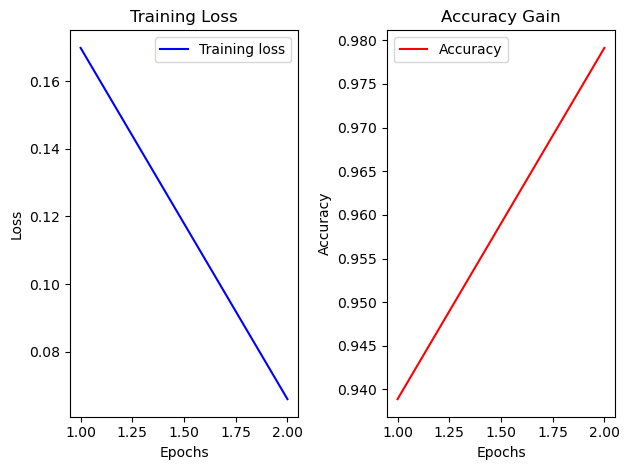

In [69]:
# getting the loss values from the history variable
loss_history = history.history['loss']
# getting the accuracy values from the history variable
accuracy_history = history.history['accuracy']

# storing the number of epochs
epochs = range(1, len(loss_history) + 1)

# creating a figure with two subplots
fig, ax1 = plt.subplots(1,2)

# plotting the loss graph
ax1[0].plot(epochs, loss_history, 'b', label='Training loss')
# plotting the accuracy graph
ax1[1].plot(epochs, accuracy_history, 'r', label='Accuracy')

# setting the loss graph title and axis labels
ax1[0].set_title('Training Loss')
ax1[0].set_xlabel('Epochs')
ax1[0].set_ylabel('Loss')

# setting the accuracy graph title and axis labels
ax1[1].set_title('Accuracy Graph')
ax1[1].set_xlabel('Epochs')
ax1[1].set_ylabel('Accuracy')

# displaying the legend
ax1[0].legend()
ax1[1].legend()

# displaying the graphs
plt.tight_layout()
plt.show()

### Making predictions using the LSTM Model with the test data

In [70]:
# Making predictions of X_test_lstm using the LSTM model
lstm_pred = LSTM_model.predict(X_test_lstm)

308/308 [==============================] - 703s 2s/step


In [71]:
# converting the predicted values to 0 or 1 integer, to be classified as Real or Fake News
lstm_transformed_pred = (lstm_pred > 0.499).astype(int)

### Storing the LSTM  and the Tokenizer

In [72]:
# storing the tokenizer in the tokenizer.pkl file
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [148]:
# storing the LSTM model in the trained_lstm_model.pkl file
pickle.dump(LSTM_model, open('trained_lstm_model.pkl', 'wb'))

In [55]:
# reading back the tokenizer in the tokenizer.pkl file
load_tokenizer=pickle.load(open('tokenizer.pkl', 'rb'))

In [56]:
# reading back the LSTM model in the trained_lstm_model.pkl file
load_lstm_model=pickle.load(open('trained_lstm_model.pkl', 'rb'))

## Results

### Calculating the accuracy scores for the 2 feature extractor's data (for Naive Bayes)

In [109]:
# storing the Naive Bayes Model score using the Count vectorizer
score1 = metrics.accuracy_score(y_test, improved_count_pred)
# storing the Naive Bayes Model score using the TF-IDF vectorizer
score2 = metrics.accuracy_score(y_test, improved_tfidf_pred)

In [110]:
# printing the Naive Bayes Model scores using the 2 vectorizers
print("Accuracy Scores of Naive Bayes model:")
print("Using Count Vectorizer:", score1*100, "%")
print("Using TF-IDF Vectorizer:", score2*100, "%")

Accuracy Scores of Naive Bayes model:
Using Count Vectorizer: 92.70896888346553 %
Using TF-IDF Vectorizer: 91.04128533658735 %


### Calculating the accuracy scores for the LSTM model

In [78]:
# printing the LSTM model accuracy score
lstm_accuracy_score = metrics.accuracy_score(y_test_lstm, lstm_transformed_pred)
print("Accuracy Score of LSTM model:", lstm_accuracy_score*100, "%")

Accuracy Score of LSTM model: 97.52898108602807 %


In [79]:
# storing the various models in an array
models = ["Naive Bayes", "LSTM"]
# storing the different colours in an array
colours = ['lightblue', 'lightgreen']

### Calculating the recall scores for the 2 models

In [80]:
# printing the Naive Bayes model recall score
print("Recall Score of Naive Bayes model:")
recall_nb_score = metrics.recall_score(y_test, improved_count_pred)
print("Using Count Vectorizer:", recall_nb_score*100, "%")

Recall Score of Naive Bayes model:
Using Count Vectorizer: 93.93877551020408 %


In [81]:
# printing the LSTM model recall score
recall_lstm_score = metrics.recall_score(y_test, lstm_transformed_pred)
print("Recall Score of LSTM model:", recall_lstm_score*100, "%")

Recall Score of LSTM model: 96.61224489795919 %


### Calculating the precision scores for the 2 models

In [82]:
# printing the Naive Bayes model precision score
print("Precision Score of Naive Bayes model:")
precision_nb_score = metrics.precision_score(y_test, improved_count_pred)
print("Using Count Vectorizer:", precision_nb_score*100, "%")

Precision Score of Naive Bayes model:
Using Count Vectorizer: 91.63846306987857 %


In [83]:
# printing the LSTM model precision score
precision_lstm_score = metrics.precision_score(y_test, lstm_transformed_pred)
print("Precision Score of LSTM model:", precision_lstm_score*100, "%")

Precision Score of LSTM model: 98.39950114321347 %


### Calculating the f1 scores for the 2 models

In [84]:
# printing the Naive Bayes model f1 score
print("F-1 Score of Naive Bayes model:")
f1_nb_score = metrics.f1_score(y_test, improved_count_pred)
print("Using Count Vectorizer:", f1_nb_score*100, "%")

F-1 Score of Naive Bayes model:
Using Count Vectorizer: 92.77436259195808 %


In [85]:
# printing the LSTM model f1 score
f1_lstm_score = metrics.f1_score(y_test, lstm_transformed_pred)
print("F-1 Score of LSTM model:", f1_lstm_score*100, "%")

F-1 Score of LSTM model: 97.49768303985171 %


### Preparing the confusion matrix for the 2 models

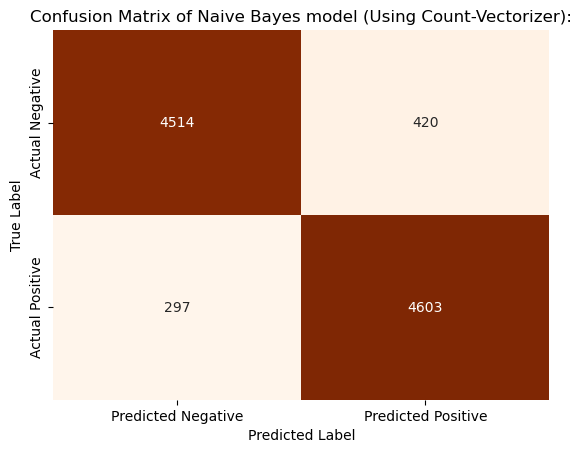

In [86]:
nb_cm = metrics.confusion_matrix(y_test, improved_count_pred)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Naive Bayes model (Using Count-Vectorizer):')

# displaying the Naive Bayes model confusion matrix
plt.show()

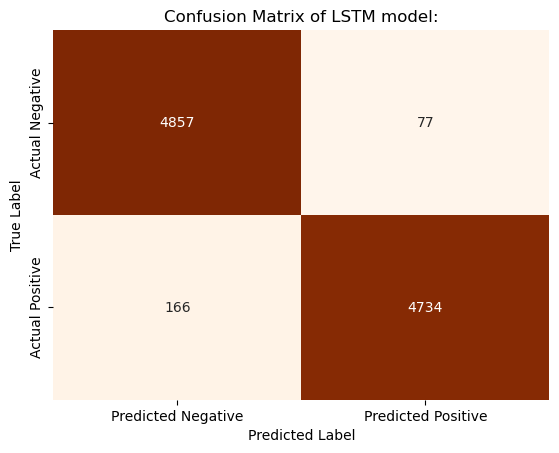

In [87]:
lstm_cm = metrics.confusion_matrix(y_test, lstm_transformed_pred)
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of LSTM model:')

# displaying the LSTM model confusion matrix
plt.show()

## Evaluation of Results

### Accuracy Scores of 2 models

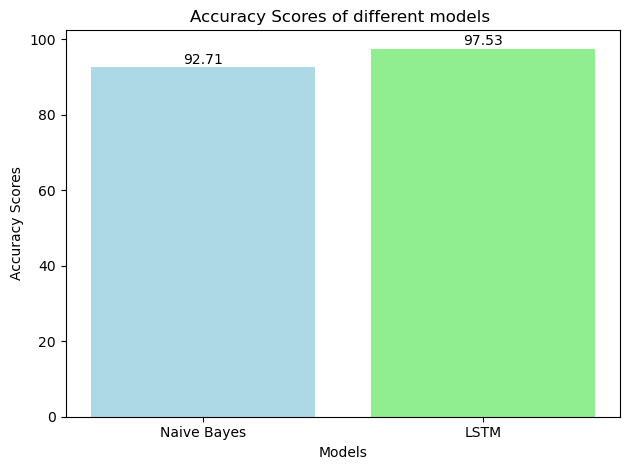

In [111]:
# storing the various accuracy scores of the models in an array
accuracy_scores = [score1*100, lstm_accuracy_score*100]
rounded_accuracy_scores = [round(score1*100, 2), round(lstm_accuracy_score*100, 2)]

# plotting the retrieved accuracy scores as a bar chart
plt.bar(models, rounded_accuracy_scores, color=colours)
plt.title("Accuracy Scores of different models ")

# displaying the recall scores on top of the respective bar graphs
for i, count in enumerate(rounded_accuracy_scores):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
    
# setting the axis labels
plt.xlabel("Models")
plt.ylabel("Accuracy Scores")

# displaying the graph
plt.tight_layout()
plt.show()

### Recall Scores of 2 models

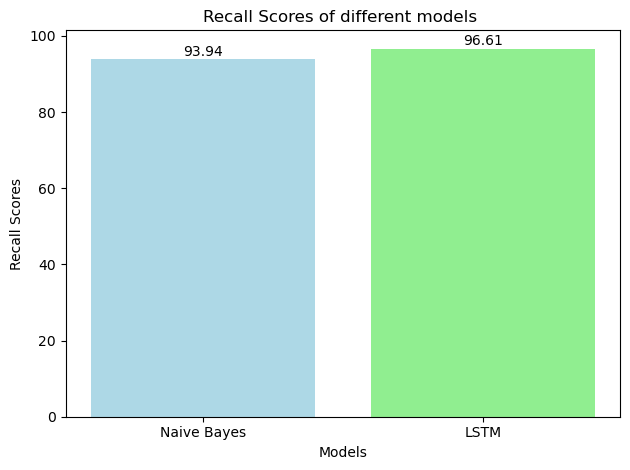

In [89]:
# storing the various recall scores of the models in an array
recall_scores = [recall_nb_score*100, recall_lstm_score*100]
rounded_recall_scores = [round(recall_nb_score*100, 2), round(recall_lstm_score*100, 2)]

# plotting the retrieved recall scores as a bar chart
plt.bar(models, rounded_recall_scores, color=colours)
plt.title("Recall Scores of different models ")

# displaying the recall scores on top of the respective bar graphs
for i, count in enumerate(rounded_recall_scores):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
    
# setting the axis labels
plt.xlabel("Models")
plt.ylabel("Recall Scores")

# displaying the graph
plt.tight_layout()
plt.show()

### Precision Scores of 2 models

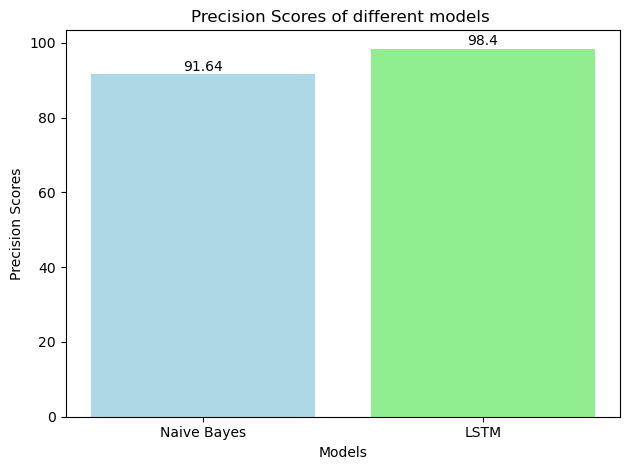

In [90]:
# storing the various precision scores of the models in an array
precision_scores = [precision_nb_score*100, precision_lstm_score*100]
rounded_precision_scores = [round(precision_nb_score*100, 2), round(precision_lstm_score*100, 2)]

# plotting the retrieved precision scores as a bar chart
plt.bar(models, rounded_precision_scores, color=colours)
plt.title("Precision Scores of different models ")

# displaying the recall scores on top of the respective bar graphs
for i, count in enumerate(rounded_precision_scores):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
    
# setting the axis labels
plt.xlabel("Models")
plt.ylabel("Precision Scores")

# displaying the graph
plt.tight_layout()
plt.show()

### F1 Scores of 2 models

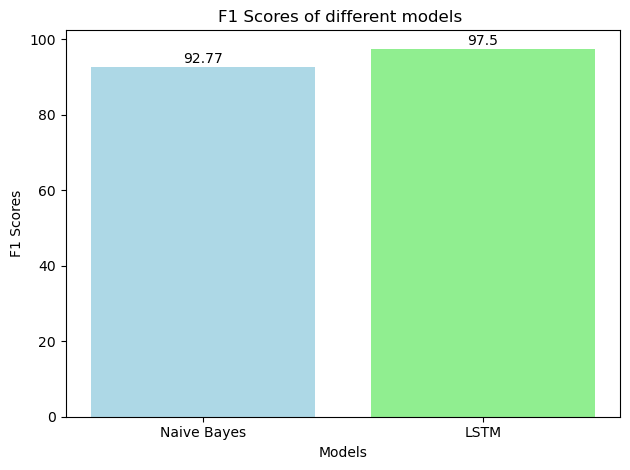

In [91]:
# storing the various f1 scores of the models in an array
f1_scores = [f1_nb_score*100, f1_lstm_score*100]
rounded_f1_scores = [round(f1_nb_score*100, 2), round(f1_lstm_score*100, 2)]

# plotting the retrieved f1 scores as a bar chart
plt.bar(models, rounded_f1_scores, color=colours)
plt.title("F1 Scores of different models ")

# displaying the recall scores on top of the respective bar graphs
for i, count in enumerate(rounded_f1_scores):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
    
# setting the axis labels
plt.xlabel("Models")
plt.ylabel("F1 Scores")

# displaying the graph
plt.tight_layout()
plt.show()

## Implementation of Models

### Using Model for Fake News Detection

In [57]:
# function to make predictions of the news using the output values
def output_prediction_label(n):
    if n == 0:
        return "Fake News"
    if n == 1:
        return "Real News(Not A Fake News)"

In [58]:
# function to calculate the confidence score of the model when making predictions of a particular news article
def calculate_confidence_value(value):
    # if the article has a score of 0-0.5, it is a Fake news. The score is mapped to a confidence score of 100%.
    if 0 <= value < 0.5:
        calculated_percentage = ((0.5 - value) / (0.5)) * 100
    # if the article has a score of 0.5-1, it is a Real news. The score is mapped to a confidence score of 100%.
    elif 0.5 <= value <= 1:
        calculated_percentage = ((value - 0.5)/ 0.5) * 100
    # if no score is returned, no score is printed. (To handle exceptions)
    else:
        calculated_percentage = None
    return calculated_percentage

In [59]:
# function to make predictions of a news article using a news text, initialized vectorizer and tokenizer.
def news_test(news, vectorizer, tokenizer):
    # storing the news article in the test_news["text"] as an array
    test_news = {"text": [news]}
    # storing the test_news in the new_def_test inside a dataframe
    new_def_test = pd.DataFrame(test_news)
    # cleaning the new_def_test["text"] data
    new_def_test["text"] = new_def_test["text"].apply(clean_data)
    # storing the new_def_test["text"] data as a new variable
    new_x_test = new_def_test["text"]
    # using a vectorizer to transform the new_def_test["text"] data
    new_xv_test = vectorizer.transform(new_x_test)
    # making a prediction of the news article using the Naive Bayes model
    pred_NB = load_nb_model.predict(new_xv_test)
    
    # converting the news into a string and using the tokenizer to convert the news text to a sequence and storing it
    lstm_new_xv_test = tokenizer.texts_to_sequences([str(news)])
    input_sequence_length = X_train_lstm.shape[1]
    # padding the tokenized news sequences to be of max length that suits the LSTM model input length and storing it
    lstm_new_xv_test = pad_sequences(lstm_new_xv_test, maxlen=input_sequence_length)
    
    # making a prediction of the news article using the LSTM model
    pred_LSTM = load_lstm_model.predict(lstm_new_xv_test)
    # converting the predicted values to an integer(0 or 1), to be classified as Real or Fake News
    pred_transformed_LSTM = (pred_LSTM > 0.499).astype(int)
    
    # printing the predictions of the models
    print(pred_LSTM[0][0])
    print(pred_NB[0])
    
    # returning 4 items(2 predictions and 2 confidence scores of the 2 models)
    # (set 1) the predicted LSTM value(0 or 1) to classify as Real/Fake News and confidence score of the LSTM model
    # (set 2) the predicted Naive Bayes value(0 or 1) to classify as Real/Fake News and confidence score of the Naive Bayes model
    return output_prediction_label(pred_transformed_LSTM[0]), calculate_confidence_value(pred_transformed_LSTM[0][0]), output_prediction_label(pred_NB[0]), calculate_confidence_value(pred_NB[0])

In [68]:
# taking in the news input
news_input = input("Enter a news string: ")
# storing the 4 outputs from the news test function using the news input, vectorizer and tokenizer
lstm_prediction, lstm_confidence_score, nb_prediction, nb_confidence_score = news_test(news_input, load_vectorizer, load_tokenizer)

Enter a news string: No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing Opinion Radio Show. A snapshot of her #FYF911 @LOLatWhiteFear Twitter page at 9:53 p.m. shows that she was urging supporters to  Call now!! #fyf911 tonight we continue to dismantle the illusion of white Below is a SNAPSHOT Twitter Radio Call Invite   #FYF911The radio show aired at 10:00 p.m. eastern standard time.During the show, callers clearly call for  lynching  and  killing  of white people.A 2:39 minute clip from the radio show can be heard here. It was provided to Breitbart Texas by someone who would li

In [69]:
# printing the 4 outputs from the news test function
# printing the LSTM prediction output (whether the article is Fake News or Real News)
print("LSTM Prediction:", lstm_prediction)
# printing the LSTM model confidence score of the prediction
print("LSTM Confidence Score:", lstm_confidence_score, "%")
# printing the Naive Bayes prediction output (whether the article is Fake News or Real News)
print("NB Prediction:", nb_prediction)
# printing the Naive Bayes model confidence score of the prediction
print("NB Confidence Score:", nb_confidence_score, "%")

LSTM Prediction: Real News(Not A Fake News)
LSTM Confidence Score: 100.0 %
NB Prediction: Real News(Not A Fake News)
NB Confidence Score: 100.0 %


In [147]:
# printing the Generic Accuracy scores of the 2 models
print("Accuracy Scores of the 2 models:")
# printing the Generic Accuracy scores of the LSTM model
print("LSTM Model Generic Accuracy Score:", round(lstm_accuracy_score*100, 2), "%")
# printing the Generic Accuracy scores of the Naive Bayes model
print("Naive Bayes Model Generic Accuracy Score:", round(improved_count_score*100, 2), "%")

Accuracy Scores of the 2 models:
LSTM Model Generic Accuracy Score: 97.53 %
Naive Bayes Model Generic Accuracy Score: 92.71 %


In [98]:
#### Demo Fake News Article
#### HARARE (Reuters) - Zimbabwe President Robert Mugabe arrived at a university graduation ceremony in the capital on Friday, his first public appearance since a military seizure of power that political sources say is aimed at ending his 37 years in office. Wearing a blue and yellow academic gown and mortar board hat, the 93-year-old sat in large wooden chair at the front the hall. He was greeted by ululations from the crowd as he declared the ceremony open.

In [99]:
#### Demo Real News Article
#### No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing Opinion Radio Show. A snapshot of her #FYF911 @LOLatWhiteFear Twitter page at 9:53 p.m. shows that she was urging supporters to  Call now!! #fyf911 tonight we continue to dismantle the illusion of white Below is a SNAPSHOT Twitter Radio Call Invite   #FYF911The radio show aired at 10:00 p.m. eastern standard time.During the show, callers clearly call for  lynching  and  killing  of white people.A 2:39 minute clip from the radio show can be heard here. It was provided to Breitbart Texas by someone who would like to be referred to as  Hannibal.  He has already received death threats as a result of interrupting #FYF911 conference calls.An unidentified black man said  when those mother f**kers are by themselves, that s when when we should start f***ing them up. Like they do us, when a bunch of them ni**ers takin  one of us out, that s how we should roll up.  He said,  Cause we already roll up in gangs anyway. There should be six or seven black mother f**ckers, see that white person, and then lynch their ass. Let s turn the tables. They conspired that if  cops started losing people,  then  there will be a state of emergency. He speculated that one of two things would happen,  a big-ass [R s?????] war,  or  ni**ers, they are going to start backin  up. We are already getting killed out here so what the f**k we got to lose? Sunshine could be heard saying,  Yep, that s true. That s so f**king true. He said,  We need to turn the tables on them. Our kids are getting shot out here. Somebody needs to become a sacrifice on their side.He said,  Everybody ain t down for that s**t, or whatever, but like I say, everybody has a different position of war.  He continued,  Because they don t give a f**k anyway.  He said again,  We might as well utilized them for that s**t and turn the tables on these n**ers. He said, that way  we can start lookin  like we ain t havin  that many casualties, and there can be more causalities on their side instead of ours. They are out their killing black people, black lives don t matter, that s what those mother f**kers   so we got to make it matter to them. Find a mother f**ker that is alone. Snap his ass, and then f***in hang him from a damn tree. Take a picture of it and then send it to the mother f**kers. We  just need one example,  and  then people will start watchin .  This will turn the tables on s**t, he said. He said this will start  a trickle-down effect.  He said that when one white person is hung and then they are just  flat-hanging,  that will start the  trickle-down effect.  He continued,  Black people are good at starting trends. He said that was how  to get the upper-hand. Another black man spoke up saying they needed to kill  cops that are killing us. The first black male said,  That will be the best method right there. Breitbart Texas previously reported how Sunshine was upset when  racist white people  infiltrated and disrupted one of her conference calls. She subsequently released the phone number of one of the infiltrators. The veteran immediately started receiving threatening calls.One of the #F***YoFlag movement supporters allegedly told a veteran who infiltrated their publicly posted conference call,  We are going to rape and gut your pregnant wife, and your f***ing piece of sh*t unborn creature will be hung from a tree. Breitbart Texas previously encountered Sunshine at a Sandra Bland protest at the Waller County Jail in Texas, where she said all white people should be killed. She told journalists and photographers,  You see this nappy-ass hair on my head?   That means I am one of those more militant Negroes.  She said she was at the protest because  these redneck mother-f**kers murdered Sandra Bland because she had nappy hair like me. #FYF911 black radicals say they will be holding the  imperial powers  that are actually responsible for the terrorist attacks on September 11th accountable on that day, as reported by Breitbart Texas. There are several websites and Twitter handles for the movement. Palmetto Star  describes himself as one of the head organizers. He said in a YouTube video that supporters will be burning their symbols of  the illusion of their superiority,  their  false white supremacy,  like the American flag, the British flag, police uniforms, and Ku Klux Klan hoods.Sierra McGrone or  Nocturnus Libertus  posted,  you too can help a young Afrikan clean their a** with the rag of oppression.  She posted two photos, one that appears to be herself, and a photo of a black man, wiping their naked butts with the American flag.For entire story: Breitbart News